## LOAD AND PREVIEW THE DATA

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError

drugs_df = pd.read_csv("drugs.csv")
chembl_df = pd.read_csv("ChEMBL.csv")

drugs_df.drop(columns=["index","row ID","Molecule","Molecule name"],inplace=True, errors="ignore")

drugs_df.dropna(inplace=True)
chembl_df.dropna(subset=["pXC50_3D7"],inplace=True)

drugs_df.reset_index(drop=True,inplace=True)
chembl_df.reset_index(drop=True,inplace=True)

N = min(len(drugs_df),len(chembl_df))
drugs_df = drugs_df.iloc[ :N]
chembl_df = chembl_df.iloc[ :N]

print("final shape:", drugs_df.shape)


final shape: (13389, 30)


## PREPARE FEATURES AND TARGET
### data visualization

X shape:  (13389, 23)
y shape:  (13389,)


c:\Users\Shreeya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 10.0821 - mae: 2.2132 - val_loss: 0.4769 - val_mae: 0.4603
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7641 - mae: 0.6532 - val_loss: 0.2814 - val_mae: 0.3630
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5898 - mae: 0.5567 - val_loss: 0.2356 - val_mae: 0.3400
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4328 - mae: 0.4887 - val_loss: 0.2081 - val_mae: 0.3289
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3824 - mae: 0.4504 - val_loss: 0.1881 - val_mae: 0.2840
Epoch 6/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3043 - mae: 0.3966 - val_loss: 0.1794 - val_mae: 0.3038
Epoch 7/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2657 - mae: 0.3666 - val_loss: 0.1680 - val_mae: 0.2677
Epoch 8/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2594 - mae: 0.3408 - val_loss: 0.1796 - val_mae: 0.2633
Epoch 9/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - l

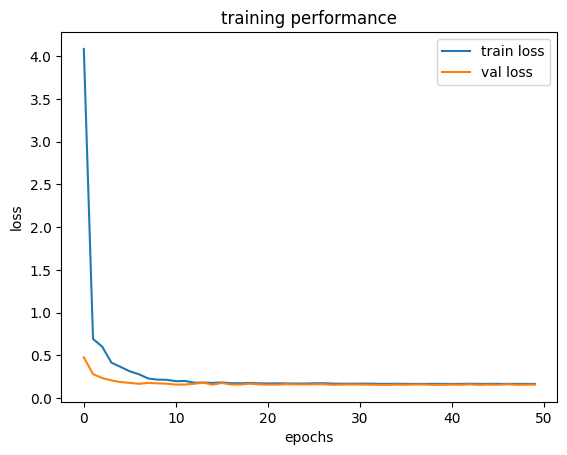

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


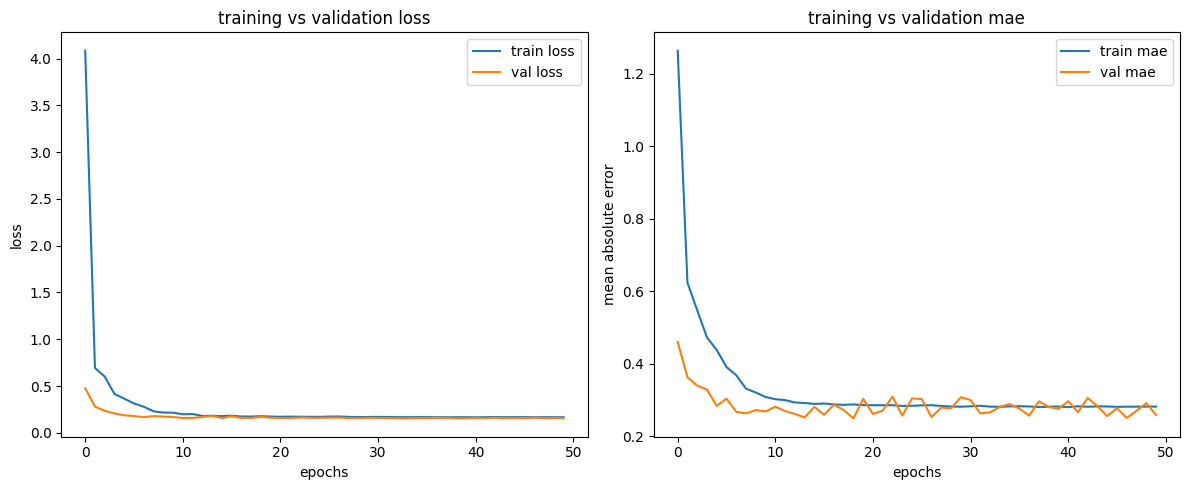

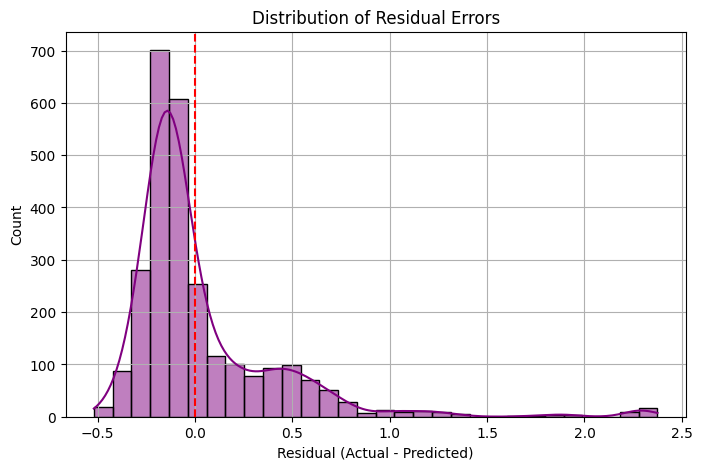

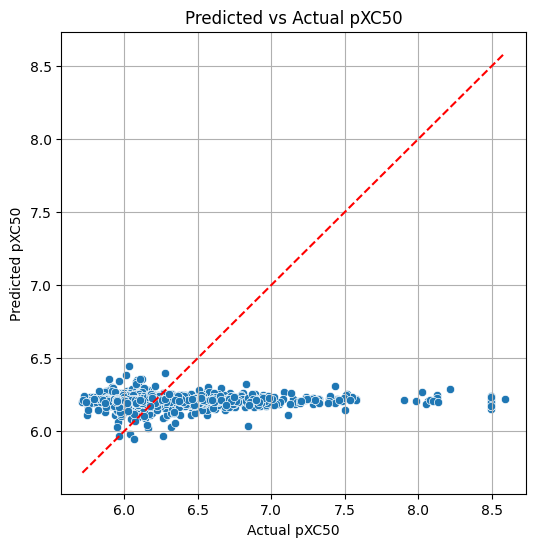

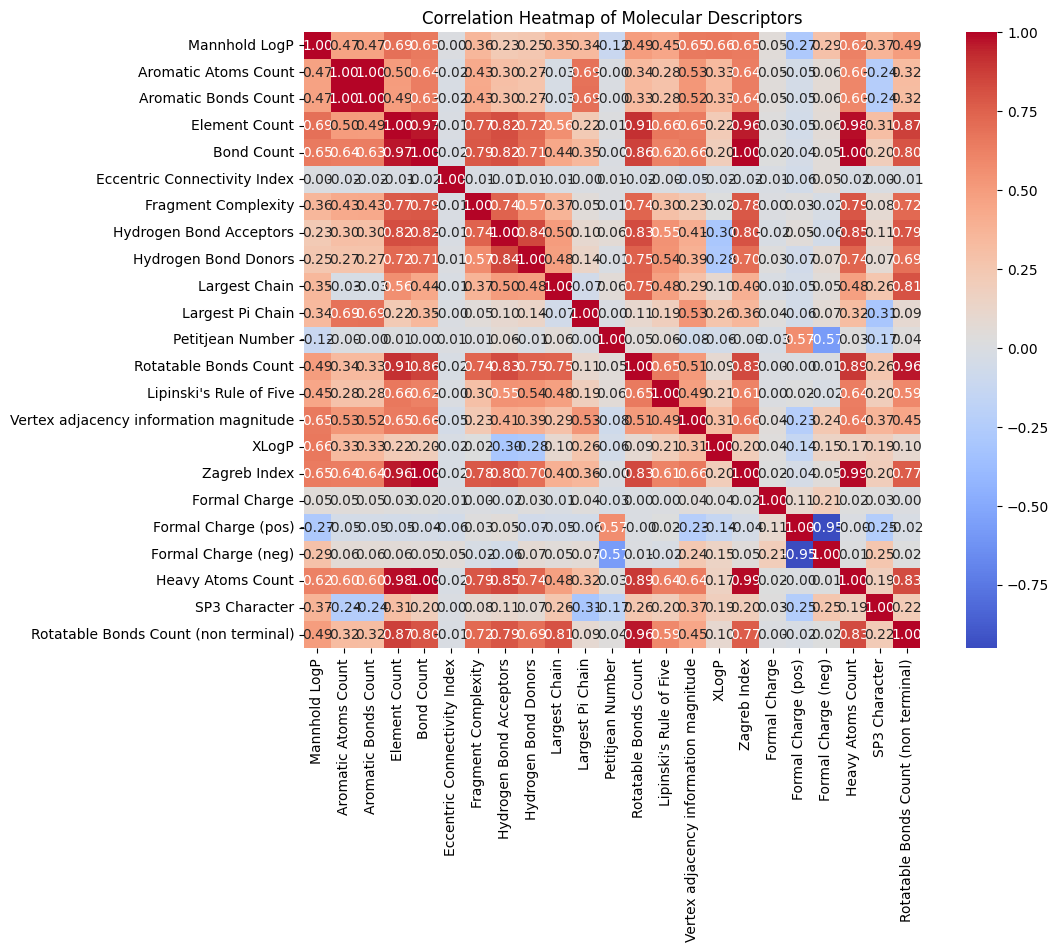

In [4]:
y = chembl_df["pXC50_3D7"].values

X = drugs_df.select_dtypes(include=['float64','int64'])

print("X shape: ",X.shape)
print("y shape: ",y.shape)

# train test and split 


X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = Sequential([Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),Dropout(0.3),Dense(64, activation='relu'),Dense(1)])

model.compile(optimizer='adam',loss=MeanSquaredError(),metrics=['mae'])

history = model.fit(X_train_scaled, y_train,epochs=50, batch_size=16,validation_split=0.2)

loss, mae = model.evaluate(X_test_scaled, y_test)
print("test mae: ",mae)

plt.plot(history.history['loss'], label = "train loss")
plt.plot(history.history['val_loss'],label="val loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("training performance")
plt.show()

y_pred = model.predict(X_test_scaled).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label="train loss")
plt.plot(history.history['val_loss'],label="val loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("training vs validation loss")

plt.subplot(1,2,2)
plt.plot(history.history['mae'],label="train mae")
plt.plot(history.history['val_mae'],label="val mae")
plt.xlabel("epochs")
plt.ylabel("mean absolute error")
plt.legend()
plt.title("training vs validation mae")
plt.tight_layout()
plt.show()


residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Distribution of Residual Errors")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual pXC50")
plt.ylabel("Predicted pXC50")
plt.title("Predicted vs Actual pXC50")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Molecular Descriptors")
plt.show()

In [8]:
import joblib

model.save("drug_model.h5")
joblib.dump(scaler, "scaler.pkl")
X.columns.to_series().to_csv("feature_names.txt", index=False,header=False)

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"🔁 Fold {fold + 1}")

    # Split data for this fold
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Scale
    scaler_cv = StandardScaler()
    X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
    X_val_cv_scaled = scaler_cv.transform(X_val_cv)

    # Build model
    model_cv = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_cv_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model_cv.compile(optimizer='adam', loss='mse')

    # Train model
    model_cv.fit(X_train_cv_scaled, y_train_cv, epochs=30, batch_size=16, verbose=0)

    # Predict and evaluate
    y_pred_cv = model_cv.predict(X_val_cv_scaled).flatten()
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    mae_scores.append(mae)
    print(f"Fold {fold+1} MAE: {mae:.4f}")

print("\n✅ Cross-Validation MAE scores:", mae_scores)
print("📊 Average MAE across folds:", np.mean(mae_scores))

🔁 Fold 1


c:\Users\Shreeya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 MAE: 0.2557
🔁 Fold 2


c:\Users\Shreeya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 MAE: 0.2540
🔁 Fold 3


c:\Users\Shreeya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 MAE: 0.2854
🔁 Fold 4


c:\Users\Shreeya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 MAE: 0.2704
🔁 Fold 5


c:\Users\Shreeya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5 MAE: 0.2846

✅ Cross-Validation MAE scores: [0.25573256062741956, 0.2539729312823226, 0.28544105364548084, 0.2703544034482402, 0.28455156093484835]
📊 Average MAE across folds: 0.2700105019876623


In [7]:
with open("feature_names.txt", "r") as f:
    features = f.readlines()
print("Features used in the model:",len(features))

Features used in the model: 24
